# Social Mobility in England 2018

A recent report analysed social mobility across Great Britain (GB) and came to some interesting, but unsurprising conclusions.  In this piece, I intend to use the data collected by the Social Mobility Commission to reproduce their map and highlight some of the key points that are alluded to in the report.

The data can be found at https://www.gov.uk/government/publications/social-mobility-index-2017-data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm 
import pandas as pd
import seaborn as sns
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
plt.style.use('ggplot')

In [2]:
pd.__version__

'0.22.0'

In [3]:
# import the data
df = pd.read_excel("data/SMI_2017_Final_v1.1.xlsx",
                   sheet_name="Standardised scores",
                   header=2,
                   usecols="B:Y")
#df.set_index('Code')
df.head()

,Code,Local Authority,Region,Overall score,Early Years,Schools,Youth,Adulthood,% of nursery providers rated 'outstanding' or 'good' by Ofsted,% of children eligible for FSM achieving a 'good level of development' at the end of Early Years Foundation Stage,...,"% of young people eligible for FSM that are not in education, employment or training (positive destination) after completing KS4",Average points score per entry for young people eligible for FSM at age 15 taking A-level or equivalent qualifications,% of young people eligible for FSM at age 15 achieving 2 or more A-levels or equivalent qualifications by the age of 19,% of young people eligible for FSM at age 15 entering higher education by the age of 19,% of young people eligible for FSM at age 15 entering higher education at a selective university (most selective third by UCAS tariff scores) by the age of 19,"Median weekly salary (£) of employees who live in the local area, all employees (FT and PT)",Average house prices compared to median annual salary of employees who live in the local area,% of people that live in the local area who are in managerial and professional occupations (SOC 1 and 2),% of jobs that are paid less than the applicable Living Wage Foundation living wage,% of families with children who own their home
0,E07000223,Adur,South East,-10.005418,-5.666597,2.434496,0.209065,-6.982383,0.859669,-1.312997,...,-0.498967,0.682223,-0.175964,-0.302059,0.336579,-0.125560,-1.050543,-0.519266,0.251691,0.047202
1,E07000026,Allerdale,North West,-66.976652,-19.811003,-29.941335,-12.771984,-4.452329,0.530856,-2.115736,...,-0.748451,-0.216886,-0.804414,-0.587092,-0.197554,-0.194325,0.846600,-0.342189,-1.406377,0.205826
2,E07000032,Amber Valley,East Midlands,-47.412538,5.233444,-37.530302,-22.206092,7.090412,-0.007096,0.425772,...,-0.997934,-0.472485,-1.447933,-0.842790,-0.680076,-0.054757,0.777829,0.131611,-0.055757,0.619157
3,E07000224,Arun,South East,-30.579008,-0.316019,-18.224905,4.054784,-16.092867,0.859669,-0.884951,...,0.997934,0.611185,-0.832683,-0.302059,0.336579,-0.538661,-0.699572,-0.366119,-1.555230,-0.058993
4,E07000170,Ashfield,East Midlands,-62.066681,-26.067006,-8.457679,-26.550217,-0.991779,-0.438157,-1.647204,...,-0.997934,-0.611551,-1.660144,-1.054536,-0.985879,-0.454615,0.859643,-0.997852,0.517445,-0.122977


All we need is the (Local Authority) `Code` and the `Overall Score` so let's remove everything else.

In [4]:
local_authority_data = df[['Code', 'Overall score']].copy()
local_authority_data.head()

,Code,Overall score
0,E07000223,-10.005418
1,E07000026,-66.976652
2,E07000032,-47.412538
3,E07000224,-30.579008
4,E07000170,-62.066681


Now, the plan is to build up the full map from an initial `Basemap` of GB.  Then, we can add the data to colour the map and indicate the levels of social mobility.

/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


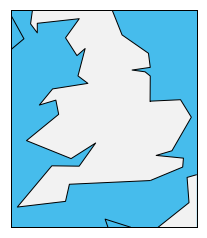

In [5]:
m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-6., llcrnrlat= 49.5, urcrnrlon=2., urcrnrlat=55.2)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

Next, add shape (or location) data which indicates the boundaries of the counties across the country.  This can be found at using the `UK postcode boundary polygons`.  The downloaded file is of `.zip` format which needs to be unzipped (unzips into a folder called `Distribution`) and moved to the correct directory.  I moved it to the same directory as the excel workbook, `~/data`.

(124,
 5,
 [-8.650847603966941, 48.89541626000005, 0.0, 0.0],
 [1.767277296953405, 60.862978679312384, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x1a17fdae48>)

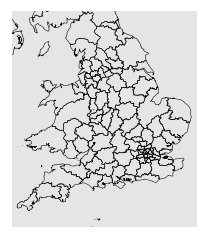

In [6]:
m.readshapefile('data/Distribution/Areas', 'areas')

Now we have:
1. The data from the excel workbook
2. The location data which determines how to plot the excel data.

The task now is to extract the correct data from the excel workbook and put it onto the map.  Examining the workbook and/or the report it seems that the column on which the mapping is based is `Overall score`.  We can define a new dataframe containing only the location data and the necessary information to colour the plot.

In [7]:
df_poly = pd.DataFrame({
    'shapes':[Polygon(np.array(shape), True) for shape in m.areas],
    'area': [area['name'] for area in m.areas_info]
})

df_poly.head()

,area,shapes
0,AB,"Poly((421327, 1.37514e+06) ...)"
1,AB,"Poly((436447, 1.4274e+06) ...)"
2,AB,"Poly((435968, 1.43447e+06) ...)"
3,AB,"Poly((445607, 1.46576e+06) ...)"
4,AL,"Poly((625874, 383221) ...)"


In [8]:
df_poly.shape

(1990, 2)

The problem now is that the plotting works by using postcode prefixes and all we have is local authority and area codes.  However, from here http://geoportal.statistics.gov.uk/datasets/a267b55f601a4319a9955b0197e3cb81_0/data it seems that there is a dataset which relates the area code and the post code.  Again, save this in the data directory so we can work with it.

EDIT - I think the data we need for this step is actually https://data.gov.uk/dataset/national-statistics-postcode-lookup-uk/resource/3206f3b9-854a-46ec-8fd2-a6823e836b65.

Is reasonably large so takes a while to download.

In [9]:
postcodes_local_authorities = pd.read_csv('data/National_Statistics_Postcode_Lookup_UK.csv', header=0)
postcodes_local_authorities.head()

,Postcode 1,Postcode 2,Postcode 3,Date Introduced,User Type,Easting,Northing,Positional Quality,County Code,County Name,...,Middle Super Output Area Code,Middle Super Output Area Name,Output Area Classification Code,Output Area Classification Name,Longitude,Latitude,Spatial Accuracy,Last Uploaded,Location,Socrata ID
0,NP4 6UW,NP4 6UW,NP4 6UW,01-2008,0,326933.0,201728.0,1,W99999999,(pseudo) Wales,...,W02000326,NaN,8B1,Hard-pressed living;Challenged terraced worker...,-3.058884,51.709509,Postcode Level,04/01/2018,"(51.709509, -3.058884)",1090478
1,PO8 9HG,PO8 9HG,PO8 9HG,01-1993,0,469118.0,112937.0,1,E10000014,Hampshire,...,E02004710,NaN,6A2,Suburbanites;Suburban achievers;Comfortable su...,-1.018240,50.911771,Postcode Level,04/01/2018,"(50.911771, -1.01824)",1244663
2,DA122BB,DA12 2BB,DA12 2BB,01-1980,0,565035.0,174333.0,1,E10000016,Kent,...,E02005056,NaN,3A2,Ethnicity central;Ethnic family life;Young fam...,0.373369,51.443945,Postcode Level,04/01/2018,"(51.443945, 0.373369)",390724
3,DA8 2NQ,DA8 2NQ,DA8 2NQ,01-1980,0,552393.0,176541.0,1,E99999999,(pseudo) England (UA/MD/LB),...,E02000072,NaN,8D2,Hard-pressed living;Migration and churn;Hard-p...,0.192557,51.467323,Postcode Level,04/01/2018,"(51.467323, 0.192557)",396798
4,ML3 7AW,ML3 7AW,ML3 7AW,01-1980,0,272538.0,655456.0,1,S99999999,(pseudo) Scotland,...,S02002384,NaN,2C3,Cosmopolitans;Comfortable cosmopolitan;Profess...,-4.033620,55.775580,Postcode Level,04/01/2018,"(55.77558, -4.03362)",979521


In [10]:
postcodes_local_authorities.columns

Index(['Postcode 1', 'Postcode 2', 'Postcode 3', 'Date Introduced',
       'User Type', 'Easting', 'Northing', 'Positional Quality', 'County Code',
       'County Name', 'Local Authority Code', 'Local Authority Name',
       'Ward Code', 'Ward Name', 'Country Code', 'Country Name', 'Region Code',
       'Region Name', 'Parliamentary Constituency Code',
       'Parliamentary Constituency Name', 'European Electoral Region Code',
       'European Electoral Region Name', 'Primary Care Trust Code',
       'Primary Care Trust Name', 'Lower Super Output Area Code',
       'Lower Super Output Area Name', 'Middle Super Output Area Code',
       'Middle Super Output Area Name', 'Output Area Classification Code',
       'Output Area Classification Name', 'Longitude', 'Latitude',
       'Spatial Accuracy', 'Last Uploaded', 'Location', 'Socrata ID'],
      dtype='object')

The only columns that we need are `Postcode 1` to strip the area from the postcode prefix and `Local Authority Code` to map this code to the post code and merge this with our data previously obtained.  We can actually do this in one step by adapting the above code to the following:

In [11]:
postcodes_local_authorities = pd.read_csv('data/National_Statistics_Postcode_Lookup_UK.csv',
                                          header=0,
                                         usecols=['Postcode 1', 'Local Authority Code'])
postcodes_local_authorities.head()

,Postcode 1,Local Authority Code
0,NP4 6UW,W06000020
1,PO8 9HG,E07000085
2,DA122BB,E07000109
3,DA8 2NQ,E09000004
4,ML3 7AW,S12000029


In [12]:
postcodes_local_authorities.rename(columns={"Postcode 1" : "postcode"}, inplace=True)
postcodes_local_authorities.head()

,postcode,Local Authority Code
0,NP4 6UW,W06000020
1,PO8 9HG,E07000085
2,DA122BB,E07000109
3,DA8 2NQ,E09000004
4,ML3 7AW,S12000029


Now we have `Local Authority Codes` and associated postcodes, so we can just take the prefix of the postcode and merge with areas data.

In [13]:
areas_and_LA_codes = postcodes_local_authorities['postcode'].str.extract(r'(\D+)', expand=True)

#postcodes_local_authorities.head()

In [14]:
areas_and_LA_codes['Local Authority Code'] = postcodes_local_authorities['Local Authority Code']

In [15]:
areas_and_LA_codes.rename(columns={ 0 : "area"}, inplace=True)
areas_and_LA_codes.head()

,area,Local Authority Code
0,NP,W06000020
1,PO,E07000085
2,DA,E07000109
3,DA,E09000004
4,ML,S12000029


Now we have three important dataframes.  The first is the data we plan to plot which measures the social mobility; this is called `local_authority_data`.  The second is the geographic location called `df_poly`, and the third is the dataframe which shows the Local Authority Code for every area: `areas_and_LA_codes`. Let's just remind ourselves of the structure:

In [16]:
local_authority_data.head()

,Code,Overall score
0,E07000223,-10.005418
1,E07000026,-66.976652
2,E07000032,-47.412538
3,E07000224,-30.579008
4,E07000170,-62.066681


In [52]:
local_authority_data.shape

(324, 2)

In [54]:
local_authority_data = local_authority_data[~local_authority_data['Overall score'].isin(['S', 'W'])]
local_authority_data.shape
#df[df.C.str.contains("XYZ") == False]

(324, 2)

In [17]:
df_poly.head()

,area,shapes
0,AB,"Poly((421327, 1.37514e+06) ...)"
1,AB,"Poly((436447, 1.4274e+06) ...)"
2,AB,"Poly((435968, 1.43447e+06) ...)"
3,AB,"Poly((445607, 1.46576e+06) ...)"
4,AL,"Poly((625874, 383221) ...)"


In [18]:
areas_and_LA_codes.head()

,area,Local Authority Code
0,NP,W06000020
1,PO,E07000085
2,DA,E07000109
3,DA,E09000004
4,ML,S12000029


Make our lives easier by renaming:

In [19]:
local_authority_data.rename(columns={"Code" : "Local Authority Code"}, inplace=True)
local_authority_data.head()

,Local Authority Code,Overall score
0,E07000223,-10.005418
1,E07000026,-66.976652
2,E07000032,-47.412538
3,E07000224,-30.579008
4,E07000170,-62.066681


Start merging the dataframes so that we can project onto a map.

In [20]:
df_poly = df_poly.merge(areas_and_LA_codes, on='area')

In [21]:
df_poly.head()

,area,shapes,Local Authority Code
0,AB,"Poly((421327, 1.37514e+06) ...)",S12000034
1,AB,"Poly((421327, 1.37514e+06) ...)",S12000033
2,AB,"Poly((421327, 1.37514e+06) ...)",S12000033
3,AB,"Poly((421327, 1.37514e+06) ...)",S12000034
4,AB,"Poly((421327, 1.37514e+06) ...)",S12000034


What this code has done is taken the `df_poly` dataframe and `merge`ed with the `areas_and_LA_codes` dataframe. The `on` argument has defined the name of the column on which to join and the `how='left'` preserves the ordering of the `df_poly` data.  Similarly, we can merge again on `Local Authority Code` with the data we plan to plot.

In [22]:
df_poly = df_poly.merge(local_authority_data, on='Local Authority Code')

In [23]:
df_poly.head()

,area,shapes,Local Authority Code,Overall score
0,AL,"Poly((625874, 383221) ...)",E07000240,48.654202
1,AL,"Poly((625874, 383221) ...)",E07000240,48.654202
2,AL,"Poly((625874, 383221) ...)",E07000240,48.654202
3,AL,"Poly((625874, 383221) ...)",E07000240,48.654202
4,AL,"Poly((625874, 383221) ...)",E07000240,48.654202


In [31]:
df_poly.shape

(2926, 4)

This looks problematic but it does seem that the Local Authority codes all begin with an "S" for Scotland.  Looking at the report, Scotland and Wales were dealt with slightly differently so perhaps the best thing to do is focus on England.  Let's try an example first: (although probably best to do this earlier on)


In [24]:
df_poly[df_poly["Local Authority Code"] == "E07000223"]

,area,shapes,Local Authority Code,Overall score
686751,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686752,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686753,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686754,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686755,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686756,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686757,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686758,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686759,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418
686760,BN,"Poly((601416, 223906) ...)",E07000223,-10.005418


In [25]:
df_poly.shape

(6865037, 4)

In [26]:
df_poly.drop_duplicates(keep='first', inplace=True)

In [27]:
#df_poly.dropna(inplace=True)

In [28]:
df_poly.shape

(2926, 4)

/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


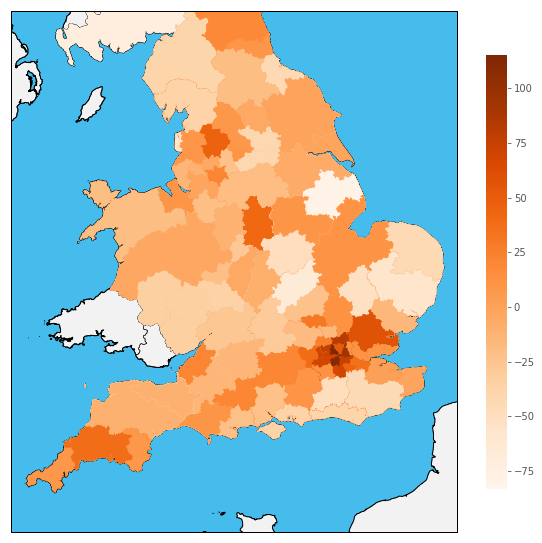

In [42]:
fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-6., llcrnrlat= 49.5,urcrnrlon=2., urcrnrlat=55.2)
             
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('data/Distribution/Areas', 'areas')
3
cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(df_poly['shapes'], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['Overall score'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Overall score'])
plt.colorbar(mapper, shrink=0.4)

m


/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


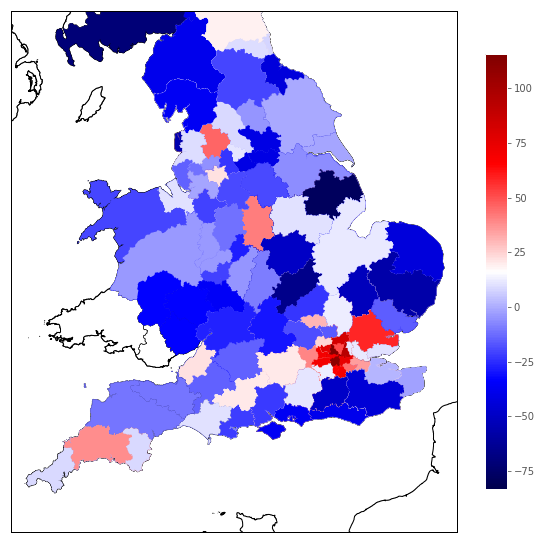

In [49]:
fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-6., llcrnrlat= 49.5,urcrnrlon=2., urcrnrlat=55.2)
             
m.drawmapboundary(fill_color='#46bcec')
#m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawmapboundary(fill_color='white')
m.drawcoastlines()
m.readshapefile('data/Distribution/Areas', 'areas')

cmap = plt.get_cmap('seismic')   
pc = PatchCollection(df_poly['shapes'], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['Overall score'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Overall score'])
plt.colorbar(mapper, shrink=0.4)

m


/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/charliedickens/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


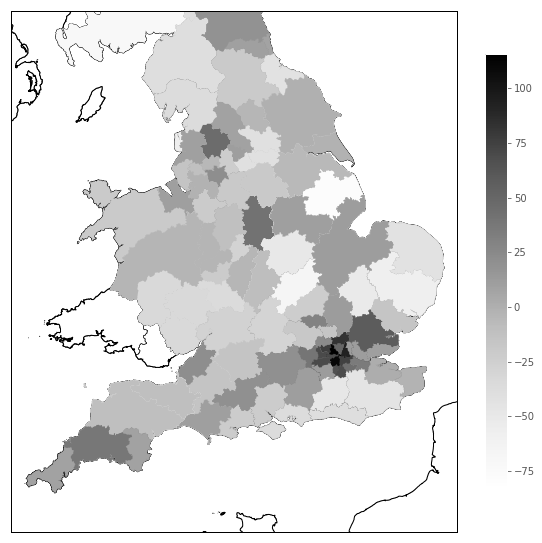

In [61]:
fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-6., llcrnrlat= 49.5,urcrnrlon=2., urcrnrlat=55.2)
             
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white',lake_color='white')
m.drawmapboundary(fill_color='white')
m.drawcoastlines()
m.readshapefile('data/Distribution/Areas', 'areas')

cmap = plt.get_cmap('Greys')   
pc = PatchCollection(df_poly['shapes'], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['Overall score'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Overall score'])
plt.colorbar(mapper, shrink=0.4)

m
